In [1]:
from scipy import stats
from scipy.spatial.distance import cdist
from scipy.spatial import cKDTree as KDTree
import statsmodels.api as sm
import numpy as np
import pandas as pd
import gdal
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def inRaster(file_raster):
    raster = gdal.Open(file_raster, gdal.GA_ReadOnly)
    band = raster.GetRasterBand(1)
    array = band.ReadAsArray()
    extent = raster.GetGeoTransform()
    return raster, array, extent

In [3]:
def saveRaster(path, array, raster, datatype=6, formatraster="GTiff"):
    # Set Driver
    format_ = formatraster #save as format
    driver = gdal.GetDriverByName( format_ )
    driver.Register()
    
    # Set Metadata for Raster output
    cols = raster.RasterXSize
    rows = raster.RasterYSize
    bands = raster.RasterCount
    datatype = 6#band.DataType
    
    # Set Projection for Raster
    outDataset = driver.Create(path, cols, rows, bands, datatype)
    geoTransform = raster.GetGeoTransform()
    outDataset.SetGeoTransform(geoTransform)
    proj = raster.GetProjection()
    outDataset.SetProjection(proj)
    
    # Write output to band 1 of new Raster
    outBand = outDataset.GetRasterBand(1)
    outBand.WriteArray(array) #save input array
    #outBand.WriteArray(dem)
    
    # Close and finalise newly created Raster
    #F_M01 = None
    outBand = None
    proj = None
    geoTransform = None
    outDataset = None
    driver = None
    datatype = None
    bands = None
    rows = None
    cols = None
    driver = None
    array = None

In [4]:
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.

    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.

    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.

    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])

    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in range(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [5]:
# read locations file and set station code as object type and change columns names
locations_file = r'D:\Projects\Pr\3492.10\KNMI//locations.csv'
locations = pd.read_csv(locations_file)
locations['SCODE'] = locations['SCODE'].astype(str).str.zfill(3)
locations.rename(columns = {'X':'X_RD'}, inplace = True)
locations.rename(columns = {'Y':'Y_RD'}, inplace = True)
locations.head()

,HCODE,SCODE,LON,LAT,X_RD,Y_RD,Z,SNAAM
0,1,210,4.42,52.16,88757.74,464535.30,-43.51,VALKENBURG
1,2,225,4.58,52.46,99802.05,497559.47,-38.40,IJMUIDEN
2,3,235,4.79,52.92,114500.72,548715.77,-41.46,DE_KOOY
3,4,240,4.77,52.30,113173.42,479401.88,-47.49,SCHIPHOL
4,5,242,4.94,53.26,125286.46,585474.16,-40.43,VLIELAND


In [6]:
# read csv data, and skip the first 81 rows and for each column skip the initial spaces
data_file = r'D:\Projects\Pr\3492.10\KNMI\KNMI_20170130_hourly//KNMI_20170130_hourly.txt'
data = pd.read_csv(data_file, skiprows=81, sep=',', skipinitialspace=True)

# for the hours subtract 1 as pandas daterange for hour goes from 0 - 23 
# but data reported from 1 - 24
data['HH'] = data['HH'] - 1
data['HH'] = data['HH'].astype(str).str.zfill(2)

# convert location id from int64 to object 
data['STN'] = data['STN'].astype(str).str.zfill(3)

# combine column year-month-day with column hour and convert to datetime
data['Datum'] = data['YYYYMMDD'].map(str) + data['HH']
data['Datum'] = pd.to_datetime(data['Datum'], format='%Y%m%d%H')

# join the data and location table on station name
data = pd.merge(data, locations, how='inner', left_on='STN', right_on='SCODE')

# set multiindex based on location and datum column
data.set_index(['STN','Datum'], inplace=True) # 
# display head(5)
#data.head()

In [7]:
# parameter to use for interpoltation
columns = 'P'
conversion = 0.1


# next line is important!@
# resample from hour values to daily values taking the AVERAGE value of the day
level_values = data.index.get_level_values
data_day = (data.groupby([level_values(i) for i in [0]] + [pd.Grouper(freq='1D', level=-1)]).mean())

# apply conversion for temperature as the notation is in 0.1 degrees Celsius (at +1.5 mNAP)
data_day[columns] *= conversion
data_day = data_day[pd.notnull(data_day[columns])]

# display head(5)
data_day.head()

YYYYMMDD          DD         FH         FF          FX  \
STN Datum                                                                
210 2016-01-01  20160101  146.250000  38.750000  38.333333   65.000000   
    2016-01-02  20160102  119.583333  63.750000  63.333333  102.500000   
    2016-01-03  20160103  157.916667  66.250000  66.666667  109.583333   
    2016-01-04  20160104  156.250000  40.416667  39.583333   66.666667   
    2016-01-05  20160105  147.916667  43.333333  45.000000   71.666667   

                        T    T10         TD        SQ          Q  ...     R  \
STN Datum                                                         ...         
210 2016-01-01  56.166667  30.25  42.958333  1.708333  12.500000  ...   NaN   
    2016-01-02  61.791667  55.75  49.958333  0.083333   4.083333  ...   NaN   
    2016-01-03  72.208333  63.50  56.583333  0.250000   7.666667  ...   NaN   
    2016-01-04  64.375000  57.50  57.250000  0.333333   6.083333  ...   NaN   
    2016-01-05  68.958333  62.25  55.125000  0.000000   2.916667  ...   NaN   

                 S   O   Y  HCODE   LON    LAT      X_RD      Y_RD      Z  
STN Datum                                                                  
210 2016-01-01 NaN NaN NaN      1  4.42  52.16  88757.74  464535.3 -43.51  
    2016-01-02 NaN NaN NaN      1  4.42  52.16  88757.74  464535.3 -43.51  
    2016-01-03 NaN NaN NaN      1  4.42  52.16  88757.74  464535.3 -43.51  
    2016-01-04 NaN NaN NaN      1  4.42  52.16  88757.74  464535.3 -43.51  
    2016-01-05 NaN NaN NaN      1  4.42  52.16  88757.74  464535.3 -43.51  

[5 rows x 29 columns]

In [8]:
# select first day of which data is available
date_selected = data_day.index.get_level_values('Datum').unique()[0]

# select all datA from stations that has data for this selected datE
day_df = data_day.iloc[data_day.index.get_level_values('Datum') == date_selected]

tree = KDTree(list(zip(day_df['X_RD'],day_df['Y_RD'])), leafsize=11)
    
day_df[[columns,'X_RD','Y_RD']].head()

,,P,X_RD,Y_RD
STN,Datum,,,
210,2016-01-01,1021.158333,88757.74,464535.30
235,2016-01-01,1021.395833,114500.72,548715.77
240,2016-01-01,1021.450000,113173.42,479401.88
242,2016-01-01,1021.408333,125286.46,585474.16
251,2016-01-01,1021.750000,152258.51,600741.73


In [9]:
# table data is finished and right shape, next load a template raster to use as base for interpolation

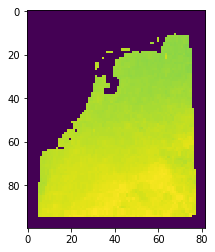

xy coordinates shape: (8200, 2) 
looks like:
 [[ -40837.58244589  696043.65059201]
 [ -40837.58244589  691043.65059201]
 [ -40837.58244589  686043.65059201]
 [ -40837.58244589  681043.65059201]
 [ -40837.58244589  676043.65059201]]


c:\python35\lib\site-packages\ipykernel\__main__.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
c:\python35\lib\site-packages\ipykernel\__main__.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [10]:
# read grid as template for IDW application
file_EUMETSAT = r'D:\Projects\Pr\3492.10\DIDSLF_NL//RD_prj_base.tif'
raster, array, extent = inRaster(file_EUMETSAT)

# plot as test
plt.imshow(array)
plt.show()

# create array with all coordinates in array using the extent
x_steps = np.arange(array.shape[1]) * extent[1]
y_steps = np.arange(array.shape[0]) * extent[-1]        
x_coords = extent[0] + x_steps + extent[1]/2
y_coords = extent[3] + y_steps + extent[-1]/2        
xy = cartesian([x_coords, y_coords])
print ('xy coordinates shape:', xy.shape, '\nlooks like:\n',xy[0:5])
array = array.T

In [11]:
# %%timeit 170x times quicker than the single np.dot approach
# IDW KDTREE
dist, idx = tree.query(xy, k=8, eps=0, p=1)
#columns = 'T'
tmp = day_df[[columns]].values.T[:, idx, None]
tmp = np.squeeze(tmp)
weights = (1/dist)**2
q = np.sum(weights, axis=1)
q = q[:,None]
weightsq =  weights / q
wz = np.einsum("ij,ij->i", weightsq, tmp)

# reshape to shape array
outArray = wz.reshape([array.shape[0],array.shape[1]]).T

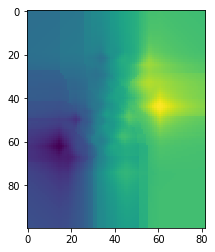

In [12]:
# plot the result for checking purposes
plt.imshow(outArray)
plt.show()

In [15]:
# save the file
baseDir = r'D:\Projects\Pr\3492.10\KNMI\InterpolatedData\P//'
path_out = os.path.join(baseDir, columns+'_2016-01-01.tif')
print ('path to save: ',path_out)
#saveRaster(path_out, outArray, raster)

path to save:  D:\Projects\Pr\3492.10\KNMI\InterpolatedData\P//P_2016-01-01.tif


In [ ]:
# Do it in batch mode!

In [ ]:
# select first day of which data is available
for date_selected in data_day.index.get_level_values('Datum').unique():

    # select all datA from stations that has data for this selected datE
    day_df = data_day.iloc[data_day.index.get_level_values('Datum') == date_selected]

    tree = KDTree(list(zip(day_df['X_RD'],day_df['Y_RD'])), leafsize=11)

    # IDW KDTREE
    dist, idx = tree.query(xy, k=8, eps=0, p=1)
    #columns = 'T'
    tmp = day_df[[columns]].values.T[:, idx, None]
    tmp = np.squeeze(tmp)
    weights = (1/dist)**2
    q = np.sum(weights, axis=1)
    q = q[:,None]
    weightsq =  weights / q
    wz = np.einsum("ij,ij->i", weightsq, tmp)

    # reshape to shape array
    outArray = wz.reshape([array.shape[0],array.shape[1]]).T   
#     im = plt.imshow(outArray)
#     plt.colorbar()
#     plt.show()

    # save the file
    file_out = columns+'_'+date_selected.strftime('%Y%m%d')+'_'+str(date_selected.dayofyear).zfill(3)+'.tif'
    path_out = os.path.join(baseDir, file_out)
    print ('path to save: ',path_out)
    saveRaster(path_out, outArray, raster)